# Artificial Neural Networks and Deep Learning



---



## Homework 1: Minimal Working Example



To make your first submission, follow these steps:

1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.

2. Upload the `training_set.npz` file to this folder.

3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.

4. Load and process the data.

5. Implement and train your model.

6. Submit the generated `.zip` file to Codabench.


## ⚙️ Import Libraries

In [3]:
import numpy as np



import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split

import random

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns



seed = 42

np.random.seed(seed)

tf.random.set_seed(seed)

## ⏳ Load and inspect the data

In [4]:
data = np.load('/kaggle/input/data-ann/training_set.npz')

X = data['images']

y = data['labels']



X = (X).astype('float32')

# Convert to one hoot encoding

y = tfk.utils.to_categorical(y)



print('Before data points filter shape:', X.shape, y.shape)



import json

with open('/kaggle/input/data-ann/blacklist.json', 'r') as file:

	blacklist = json.load(file)

blacklist = sorted(blacklist['blacklist'])

X = np.delete(X, blacklist, axis=0)

y = np.delete(y, blacklist, axis=0)



print('After data points filter shape:', X.shape, y.shape)



train_size = int(X.shape[0] * 0.8)

val_size = int(X.shape[0] * 0.1)

test_size = X.shape[0] - train_size - val_size



X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)



X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=val_size, stratify=y_train)



print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Before data points filter shape: (13759, 96, 96, 3) (13759, 8)
After data points filter shape: (11959, 96, 96, 3) (11959, 8)
(9567, 96, 96, 3) (1195, 96, 96, 3) (1197, 96, 96, 3) (9567, 8) (1195, 8) (1197, 8)


In [5]:
# Labels

labels = {

	0: "Basophil",

	1: "Eosinophil",

	2: "Erythroblast",

	3: "Immature granulocytes",

	4: "Lymphocyte",

	5: "Monocyte",

	6: "Neutrophil",

	7: "Platelet"

}

/tmp/ipykernel_30/2406154218.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return labels[int(index)]


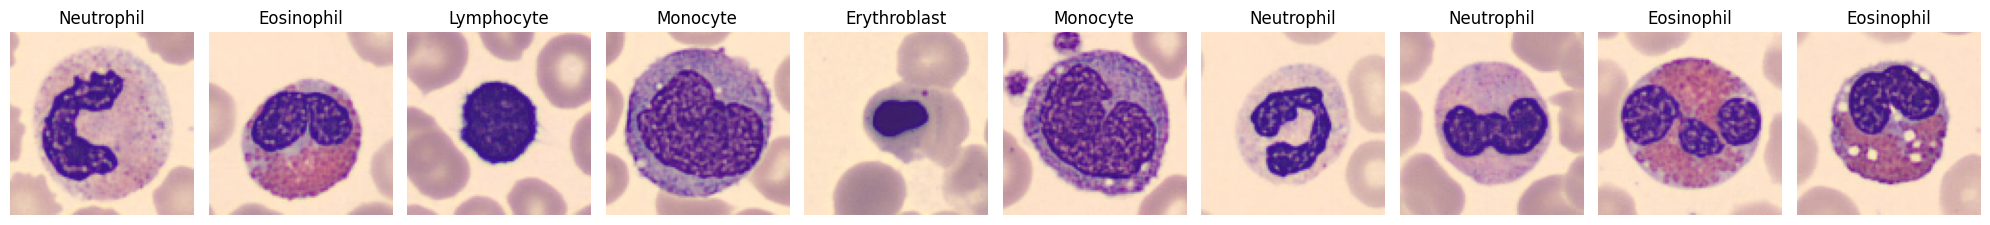

In [6]:
# Inspect data

# Display a sample of images from the training-validation dataset

num_img = 10

random_indices = random.sample(range(len(X_val)), num_img)



fig, axes = plt.subplots(1, num_img, figsize=(20, 20))



def get_label(y):

    index = np.where(y == 1)[0]

    return labels[int(index)]



# Iterate through the selected number of images

for i, idx in enumerate(random_indices):

    ax = axes[i % num_img]

    ax.imshow(np.squeeze(X_val[idx] / 255), vmin=0., vmax=1.)

    ax.set_title(get_label(y_val[idx]))

    ax.axis('off')



# Adjust layout and display the images

plt.tight_layout()

plt.show()

## 🛠️ Train and Save the Model

In [7]:
# Initialise imageNet model with pretrained weights, for transfer learning

efficientNetV2 = tfk.applications.EfficientNetV2L(

    include_top=False,

    weights="imagenet",

    input_tensor=None,

    input_shape=X_train[0].shape,

    classes=len(labels),

    pooling='avg',

    include_preprocessing=True,

    #name="efficientnetv2-l",

)



# Display a summary of the model architecture

#efficientNetV2.summary(expand_nested=True)



# Display model architecture with layer shapes and trainable parameters

#tfk.utils.plot_model(efficientNetV2, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)


473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [19]:

from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
optimizerW = AdamW(learning_rate=0.001, weight_decay=1e-5)
efficientNetV2.trainable = False

for layer in efficientNetV2.layers[-25:]:  # Sblocca gli ultimi 25 layer
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
# Define input layer with shape matching the input images

inputs = tfk.Input(shape=X_train[0].shape, name='input_layer')



# Apply data augmentation for training robustness

# TODO: enhance this



augmentation = tf.keras.Sequential([
    # Flip orizzontale e verticale
    tfkl.RandomFlip("horizontal_and_vertical"), 

    # Rotazione casuale fino a 30 gradi
    tfkl.RandomRotation(0.3),  

    # Traslazione casuale con un aumento nell'intensità
    tfkl.RandomTranslation(0.3, 0.3),  

    # Luminosità casuale con un range più ampio
    tfkl.RandomBrightness(0.3),  

    # Contrasto casuale con un range più ampio
    tfkl.RandomContrast(0.4),  

    # Zoom casuale più intenso
    tfkl.RandomZoom(0.3),  

  
 
], name='strong_preprocessing')



x = augmentation(inputs)



# Pass augmented inputs through the MobileNetV3Small feature extractor

x = efficientNetV2(x)



# Add a dropout layer for regularisation

x = tfkl.Dropout(0.4, name='dropout')(x)



# Add final Dense layer for classification with softmax activation

outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)



# Define the complete model linking input and output

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Calcola i pesi delle classi in base alla distribuzione
class_counts = np.bincount(y_train.argmax(axis=1))  # Assumendo y_train one-hot
total = np.sum(class_counts)
class_weights = {i: total / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Callback per riduzione del learning rate su plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

# Compile the model with categorical cross-entropy loss and Adam optimiser

#tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer = optimizerW, metrics=['accuracy'])



# Display a summary of the model architecture

#tl_model.summary(expand_nested=True)



# Display model architecture with layer shapes and trainable parameters

#tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
#Train the model
tl_history = tl_model.fit(

x=X_train,

y=y_train,

batch_size=64,

epochs=100,

validation_data=(X_val, y_val),

class_weight=class_weights,

#callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]

callbacks=[reduce_lr,early_stopping]
).history

#Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')

#Save the trained model to a file, including final accuracy in the filename
from datetime import datetime

model_filename = f'EfficientNetV2L{str(final_val_accuracy)}{datetime.now().strftime("%y%m%d_%H%M%S")}.keras'

tl_model.save(model_filename)

#Free memory by deleting the model instance
del tl_model

Epoch 1/100


2024-11-12 21:45:04.564474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/model_1/efficientnetv2-l_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.5804 - loss: 1.2408 - val_accuracy: 0.8251 - val_loss: 0.5002 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.7795 - loss: 0.6388 - val_accuracy: 0.8084 - val_loss: 0.5440 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.8030 - loss: 0.5777 - val_accuracy: 0.8912 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.8273 - loss: 0.5048 - val_accuracy: 0.9004 - val_loss: 0.3098 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.8270 - loss: 0.5129 - val_accuracy: 0.8971 - val_loss: 0.2998 - learning_rate: 0.0010
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.8407 - loss: 0.4706 - val_accuracy: 0.9021 - val_loss: 0.2792 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.8342 -

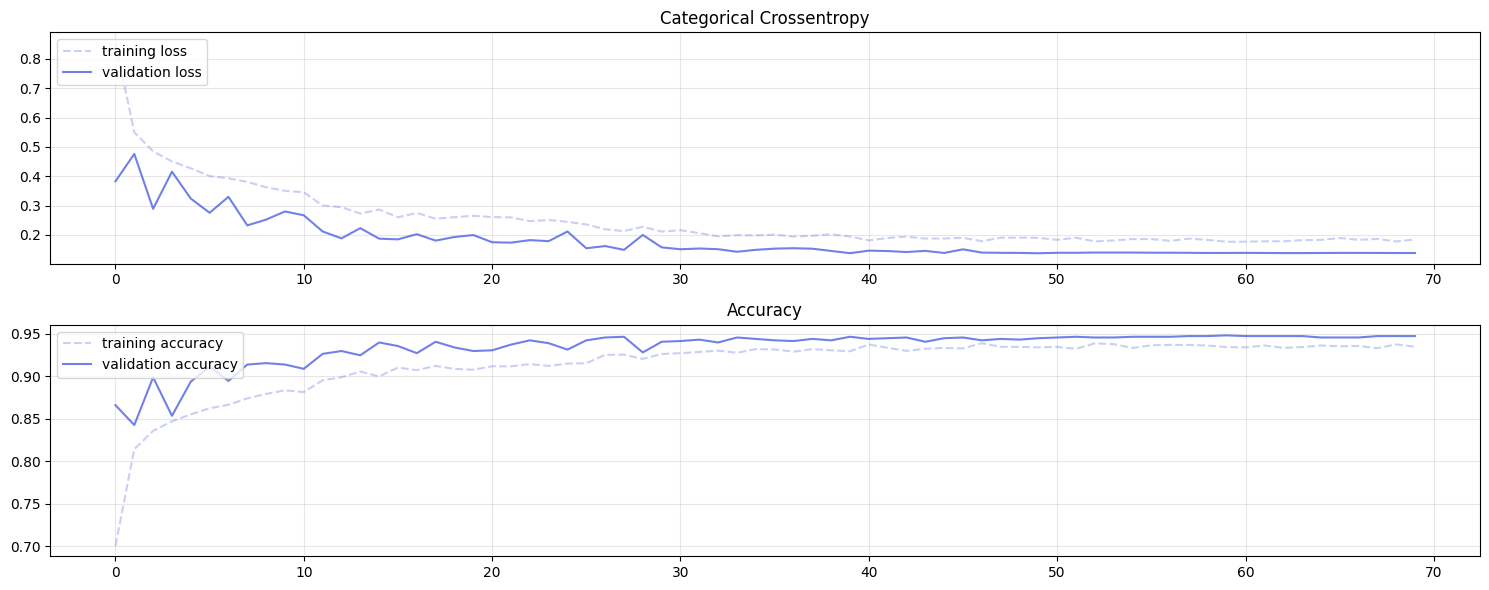

In [10]:
# Create figure and subplots for loss and accuracy

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))



# Plot loss for both re-trained and transfer learning models

ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', label='training loss', linestyle='--')

ax1.plot(tl_history['val_loss'], label='validation loss', alpha=0.8, color='#4D61E2')

ax1.set_title('Categorical Crossentropy')

ax1.legend(loc='upper left')

ax1.grid(alpha=0.3)



# Plot accuracy for both re-trained and transfer learning models

ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', label='training accuracy', linestyle='--')

ax2.plot(tl_history['val_accuracy'], label='validation accuracy', alpha=0.8, color='#4D61E2')

ax2.set_title('Accuracy')

ax2.legend(loc='upper left')

ax2.grid(alpha=0.3)



# Adjust layout to prevent label overlap and display the plots

plt.tight_layout()

plt.show()

## 👔 Load a trained model (if needed!)

In [12]:
import os

# Elenca i file nella directory di output
output_dir = '/kaggle/working/'  # o '/kaggle/output/' se stai esportando in quella cartella
for filename in os.listdir(output_dir):
    print(filename)


.virtual_documents
EfficientNetV2L94.81241112_211326.keras


In [13]:
tl_model = tf.keras.models.load_model('EfficientNetV2L94.81241112_211326.keras')

## ✍🏿 Make evaluation

Predictions Shape: (1197, 8)
Accuracy score over the test set: 0.9524
Precision score over the test set: 0.9534
Recall score over the test set: 0.9524
F1 score over the test set: 0.9524


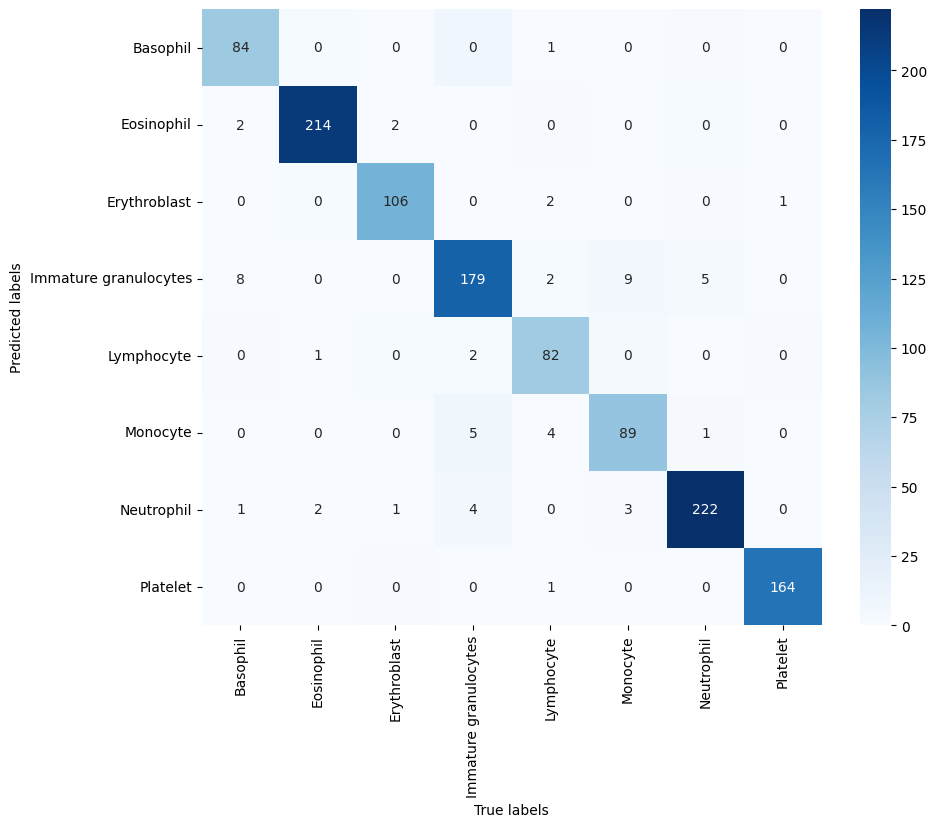

In [14]:
#loss, acc = tl_model.evaluate(X_test, y_test, verbose=2)

#print('Model, accuracy: {:5.2f}%'.format(100 * acc))



# Predict labels for the entire test set

predictions = tl_model.predict(X_test, verbose=0)



# Display the shape of the predictions

print("Predictions Shape:", predictions.shape)



# Convert predictions to class labels

pred_classes = np.argmax(predictions, axis=-1)



# Extract ground truth classes

true_classes = np.argmax(y_test, axis=-1)



# Calculate and display test set accuracy

accuracy = accuracy_score(true_classes, pred_classes)

print(f'Accuracy score over the test set: {round(accuracy, 4)}')



# Calculate and display test set precision

precision = precision_score(true_classes, pred_classes, average='weighted')

print(f'Precision score over the test set: {round(precision, 4)}')



# Calculate and display test set recall

recall = recall_score(true_classes, pred_classes, average='weighted')

print(f'Recall score over the test set: {round(recall, 4)}')



# Calculate and display test set F1 score

f1 = f1_score(true_classes, pred_classes, average='weighted')

print(f'F1 score over the test set: {round(f1, 4)}')



# Compute the confusion matrix

cm = confusion_matrix(true_classes, pred_classes)



# Combine numbers and percentages into a single string for annotation

annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)



# Plot the confusion matrix

plt.figure(figsize=(10, 8))

sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')

plt.xlabel('True labels')

plt.ylabel('Predicted labels')

plt.show()

## 📊 Prepare Your Submission



To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:



```python

# file: model.py

class Model:

    def __init__(self):

        """Initialize the internal state of the model."""



    def predict(self, X):

        """Return a numpy array with the labels corresponding to the input X."""

```



The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.



❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [15]:
%%writefile model.py

import numpy as np



import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl





class Model:

    def __init__(self):

        """

        Initialize the internal state of the model. Note that the __init__

        method cannot accept any arguments.



        The following is an example loading the weights of a pre-trained

        model.

        """

        self.neural_network = tfk.models.load_model('EfficientNetV2L94.81241112_211326.keras')



    def predict(self, X):

        """

        Predict the labels corresponding to the input X. Note that X is a numpy

        array of shape (n_samples, 96, 96, 3) and the output should be a numpy

        array of shape (n_samples,). Therefore, outputs must no be one-hot

        encoded.



        The following is an example of a prediction from the pre-trained model

        loaded in the __init__ method.

        """

        preds = self.neural_network.predict(X)

        if len(preds.shape) == 2:

            preds = np.argmax(preds, axis=1)

        return preds

Writing model.py


In [16]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'



# Add files to the zip command if needed

!zip {filename} model.py EfficientNetV2L94.81241112_211326.keras



#from google.colab import files

#files.download(filename)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: model.py (deflated 55%)
  adding: EfficientNetV2L94.81241112_211326.keras (deflated 11%)
